# Difficult to Automate Cases

## Extraction of Parameters from Volume Curves

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, find_peaks_cwt
from scipy.interpolate import InterpolatedUnivariateSpline
import peakutils

Read the data and leave as a dictionary indexed by the participant number. Each entry will be a dataframe with columns for LV and LA volumes and an index corresponding to the delay from trigger in milliseconds calculated by dividing the RR interval by the number of phases.

In [2]:
volumes = 'FullVolumes_Healthy.xlsx'
rrintervals = 'RRIntervals_Healthy.xlsx'

df_vols = pd.read_excel(volumes)
df_rrintervals = pd.read_excel(rrintervals).reset_index(drop=True)
df_rrintervals.index = ['RR']

df_la = df_vols.filter(regex='LA-[0-9]{3,3}$')
df_lv = df_vols.filter(regex='LV-[0-9]{3,3}$')
df_times = df_rrintervals.filter(regex='LV-[0-9]{3,3}$').T

nrows = df_la.count(axis=0)[0]
df_times['dT'] = df_times['RR'] / nrows
patients = {}
for patno in [int(col[-3:]) for col in df_la]:
    patients[patno] = pd.concat([
        pd.Series(np.arange(nrows) * df_times['dT']['LV-%03d' % patno], name='Time'),
        df_lv['LV-%03d' % patno],
        df_la['LA-%03d' % patno],
    ], axis=1).set_index('Time')
    patients[patno].columns = ('LV', 'LA')
    patients[patno].pat_name = 'Patient %d' % patno

In [3]:
patientno = 4

Functions to calculate LV parameters

In [4]:
def lv_es_index(volumes):
    return np.argmin(volumes)

def lv_split_at_es(volumes):
    es = lv_es_index(volumes)
    return volumes[:es], volumes[es:]

def lv_vol_at_es(volumes):
    return volumes[lv_es_index(volumes)]

def lv_vol_at_ss(volumes):
    return volumes[0]

def lv_vol_at_ed(volumes):
    return volumes[-1]

def idx_nearest(array, value, after=0):
    return np.abs(array[after:]-value).argmin() + after

def lv_idx_for_refill80_full(volumes, use_vss=True):
    vss = lv_vol_at_ss(volumes)
    ves = lv_vol_at_es(volumes)
    ved = lv_vol_at_ed(volumes)
    
    fullvol = vss if use_vss else (vss + ved) / 2
    emptyvol = ves
    
    eighty_vol = 0.2*emptyvol + 0.8*fullvol
    return idx_nearest(volumes, value=eighty_vol, after=lv_es_index(volumes))

def lv_idx_max_systolic_down_slope(volumes, slopes):
    esi = lv_es_index(volumes)
    systolic_down_slopes = -slopes[:esi]
    return systolic_down_slopes.argmax()

def lv_idx_max_recovery_slopes_orig(volumes, slopes):
    esi = lv_es_index(volumes)
    # need to further split into early and late.
    idx80 = lv_idx_for_refill80_full(volumes)
    
    diastolic_early_up_slopes = slopes[esi:idx80]
    diastolic_late_up_slopes = slopes[idx80:]
    idx_early = diastolic_early_up_slopes.argmax() + esi
    idx_late = diastolic_late_up_slopes.argmax() + idx80
    
    return idx_early, idx_late

def lv_idx_max_recovery_slopes(volumes, slopes):
    esi = lv_es_index(volumes)
    
    peaks = peakutils.indexes(slopes[esi:], thres=0.3, min_dist=3)
    print('found %d peaks' % len(peaks))
    #peaks = find_peaks_cwt(
    #    slopes[esi:],
    #    widths=np.linspace(2, 6, 10) * 3
    #)

    if len(peaks) >= 2:
        peaks = peaks[:2]
        # was sorted on height - now on time
        peaks = sorted(peaks)
        return peaks[0] + esi, peaks[1] + esi
    else:
        # fall back to splitting recovery in half
        print('falling back')
        edvol = volumes[-1]
        esvol = volumes[esi]
        partfullvol = esvol + (edvol - esvol) * 0.6
        split_idx = np.where(volumes[esi:] - partfullvol >= 0)[0][0] + esi
        early_pk_idx = slopes[esi:split_idx].argmax() + esi
        late_pk_idx = slopes[split_idx:].argmax() + split_idx
        return early_pk_idx, late_pk_idx



def lv_idx_recovery_inflexion(volumes, slopes, curvatures):
    winstart, winstop = lv_idx_max_recovery_slopes(volumes, slopes)

    peaks = find_peaks_cwt(
        -curvatures[winstart:winstop],
        widths=np.linspace(3, 5, 5) * 3
    )
    assert peaks
    print(peaks)
    peak = np.argmin(curvatures[winstart:winstop])
    print(peak)
    return peak + winstart
    #return peaks[0] + winstart

def lv_es_time(volumes, times):
    sg_volumes = savgol_filter(x=volumes, window_length=5, polyorder=2, mode='interp')
    spline = InterpolatedUnivariateSpline(times, sg_volumes)
    interpolated_time   = np.linspace(0, times[-1], len(times)*3)
    interpolated_savgol = spline(interpolated_time)
    index = lv_es_index(interpolated_savgol)
    return interpolated_time[index]

Plotting helper fuctions

In [5]:
def plot_tangent(point, slope, xmargin=60, axes=None):
    if axes is None:
        fig, axes = plt.subplots()
    x, y = point
    #print(x, y)
    y0 = y - x * slope
    
    xlower, xupper = x-xmargin, x+xmargin
    ylower, yupper = y0 + xlower*slope, y0 + xupper*slope
    
    axes.plot([xlower, x, xupper], [ylower, y, yupper], linestyle='-', linewidth=1.5, marker='>', markersize=5)

Report Parameters of Ventricular Curve

In [6]:
def plot_lv_params(patient, region='LV'):
    units, time_units = 'ml', 'ms'
    patient_name = patient.pat_name
    
    volume_series = patient[region]
    time = np.asarray(volume_series.index)
    volume = np.asarray(volume_series.values) 
    diffs = np.gradient(volume) / np.diff(time)[0]
    r_to_r = time[-1]
    sg_volume     = savgol_filter(x=volume, window_length=5, polyorder=2, mode='interp')
    dt_msecs      = np.mean(np.diff(time))
    # one order higher for the derivative sounds right .. increase window to match
    sg_derivative = savgol_filter(x=volume, window_length=7, polyorder=3, deriv=1, delta=dt_msecs, mode='interp')

    # one order higher for the derivative sounds right .. increase window to match
    sg_2nd_derivative = savgol_filter(x=volume, window_length=9, polyorder=4, deriv=2, delta=dt_msecs)
    
    spline = InterpolatedUnivariateSpline(time, sg_volume)
    spline_deriv = InterpolatedUnivariateSpline(time, sg_derivative)
    spline_2nd_deriv = InterpolatedUnivariateSpline(time, sg_2nd_derivative)

    interpolated_time   = np.linspace(0, time[-1], len(time)*3)
    interpolated_savgol = spline(interpolated_time)
    interpolated_deriv  = spline_deriv(interpolated_time)
    interpolated_2nd_deriv  = spline_2nd_deriv(interpolated_time)

    min_vol_index = lv_es_index(interpolated_savgol)
    min_vol_time  = interpolated_time[min_vol_index]
    min_volume    = interpolated_savgol[min_vol_index]
    eighty_percent_idx = lv_idx_for_refill80_full(interpolated_savgol)
    eighty_percent_time = interpolated_time[eighty_percent_idx]
    eighty_percent_vol = interpolated_savgol[eighty_percent_idx]

    max_emptying_index = lv_idx_max_systolic_down_slope(interpolated_savgol, interpolated_deriv)
    max_emptying_time = interpolated_time[max_emptying_index]
    max_emptying_vol = interpolated_savgol[max_emptying_index]
    max_emptying_slope = interpolated_deriv[max_emptying_index]
    max_emptying_curv = interpolated_2nd_deriv[max_emptying_index]
    
    max_early_filling_index, max_late_filling_index = lv_idx_max_recovery_slopes(interpolated_savgol, interpolated_deriv)
    max_early_filling_time = interpolated_time[max_early_filling_index]
    max_late_filling_time = interpolated_time[max_late_filling_index]

    max_early_filling_vol = interpolated_savgol[max_early_filling_index]
    max_late_filling_vol = interpolated_savgol[max_late_filling_index]

    max_early_filling_slope = interpolated_deriv[max_early_filling_index]    
    max_late_filling_slope = interpolated_deriv[max_late_filling_index]    

    max_early_filling_curv = interpolated_2nd_deriv[max_early_filling_index]    
    max_late_filling_curv = interpolated_2nd_deriv[max_late_filling_index]

    filling_inflexion_index = lv_idx_recovery_inflexion(interpolated_savgol, interpolated_deriv, interpolated_2nd_deriv)
    filling_inflexion_time =  interpolated_time[filling_inflexion_index]
    filling_inflexion_vol =  interpolated_savgol[filling_inflexion_index]
    filling_inflexion_slope =  interpolated_deriv[filling_inflexion_index]
    filling_inflexion_curv =  interpolated_2nd_deriv[filling_inflexion_index]

    
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax[0].plot(time, volume, '.')
    ax[0].plot(interpolated_time, interpolated_savgol, '-')
    ax[0].grid(True)
    ax[0].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[0].set_ylabel('Volume (%s)' % units)    
    ax[0].scatter(
        [max_emptying_time, min_vol_time, max_early_filling_time, eighty_percent_time, max_late_filling_time, filling_inflexion_time],
        [max_emptying_vol, min_volume, max_early_filling_vol, eighty_percent_vol, max_late_filling_vol, filling_inflexion_vol],
        s=1250, marker='+'
    )    
    
    plot_tangent((max_emptying_time, max_emptying_vol), slope=max_emptying_slope, axes=ax[0])
    plot_tangent((max_early_filling_time, max_early_filling_vol), slope=max_early_filling_slope, axes=ax[0])
    plot_tangent((max_late_filling_time, max_late_filling_vol), slope=max_late_filling_slope, axes=ax[0])

    ax[1].plot(time, diffs, '.')
    ax[1].plot(interpolated_time, interpolated_deriv, '-')
    ax[1].scatter(
        [max_emptying_time, max_early_filling_time, max_late_filling_time, filling_inflexion_time],
        [max_emptying_slope, max_early_filling_slope, max_late_filling_slope, filling_inflexion_slope],
        s=1250, marker='+'
    )
    ax[1].grid(True)
    ax[1].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[1].set_ylabel('Filling Rate (%s)' % 'ml/ms')    
    fig.suptitle('%s (%s Volume)' % (patient_name, region), fontsize=14)

    ax[2].plot(time, np.gradient(diffs)/ np.diff(time)[0], '.')
    ax[2].plot(interpolated_time, interpolated_2nd_deriv, '-')
    ax[2].scatter(
        [max_emptying_time, max_early_filling_time, max_late_filling_time, filling_inflexion_time],
        [max_emptying_curv, max_early_filling_curv, max_late_filling_curv, filling_inflexion_curv],
        s=1250, marker='+'
    )
    ax[2].grid(True)
    ax[2].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[2].set_ylabel('Filling Curvature (%s)' % 'ml/ms/ms')
    
    plt.show()

    print('R-R interval                   = %3.0f ms' % r_to_r)

    print('Time of end systole            = %3.0f ms' % min_vol_time)
    
    print('Peak LV ejection rate          = %0.3f ml/sec' % (-1000 *max_emptying_slope))
    print('Time of peak LV ejection       = %0.3f ms' % max_emptying_time)
    print('Volume at peak LV ejection     = %0.3f ml' % max_emptying_vol)    

    print('Early diastolic peak filling   = %0.3f ml/sec' % (1000 *max_early_filling_slope))
    print('Time of peak after end systole = %0.3f ms' % (max_early_filling_time - min_vol_time))
    print('Volume at early peak filling   = %0.3f ml' % max_early_filling_vol)

    print('Late diastolic peak filling    = %0.3f ml/sec' % (1000 *max_late_filling_slope))
    print('Time peak after end systole    = %0.3f ms' % (max_late_filling_time - min_vol_time))
    print('Volume at late peak filling    = %0.3f ml' % max_late_filling_vol) 
    
    print('Time of 80%% filling            = %3.0f ms' % eighty_percent_time)
    print('Time after systole for 80%%     = %3.0f ms' % (eighty_percent_time - min_vol_time))
    diastolic_time = r_to_r - min_vol_time
    print('Filling time ratio (DVR80)     = %0.3f' % ((eighty_percent_time - min_vol_time)/diastolic_time))
    


found 1 peaks
falling back
found 1 peaks
falling back
[3]
4


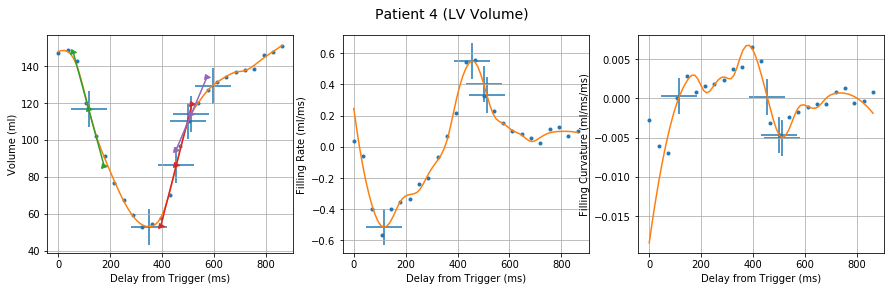

R-R interval                   = 863 ms
Time of end systole            = 350 ms
Peak LV ejection rate          = 516.740 ml/sec
Time of peak LV ejection       = 116.611 ms
Volume at peak LV ejection     = 116.712 ml
Early diastolic peak filling   = 550.614 ml/sec
Time of peak after end systole = 104.950 ms
Volume at early peak filling   = 86.310 ml
Late diastolic peak filling    = 331.588 ml/sec
Time peak after end systole    = 163.255 ms
Volume at late peak filling    = 114.161 ml
Time of 80% filling            = 595 ms
Time after systole for 80%     = 245 ms
Filling time ratio (DVR80)     = 0.477


In [7]:
plot_lv_params(patients[patientno])

Ejection and ES minumum detected reasonably but miss early peak slope as have higher (spurious) peak at end.
Need to fix in `lv_idx_max_recovery_slopes(volumes, slopes)`, where we currently currently use idx 80 as the split for early/late. Could detect best two peaks in derivative over all of rilling phase. Also, unclear whether last is really a peak as it never turns down.

OK if we use `find_peaks_cwt` we can get top two peaks provided we are careful about widths etc.

We could potentially get the turning over after this if we look at the second derivative.

Report Parameters of Atrial Curve

In [8]:
def la_es_index_orig(volumes):
    return np.argmax(volumes)

def la_es_index_cwt(volumes):
    # bias towards earlier times
    volumes_biased = volumes * (1 - 0.01 * np.arange(len(volumes))/len(volumes))    
    peaks = find_peaks_cwt(
        volumes_biased,
        widths=np.linspace(2, 6, 20)
    )
    peak = sorted(peaks, key=lambda idx: volumes_biased[idx])[-1]
    return np.argmax(volumes[peak-10:peak+10]) + peak -10

def la_es_index(volumes, window):
    start, end = window
    return start + np.argmax(volumes[start:end])

def la_split_at_es(volumes):
    es = la_es_index(volumes)
    return volumes[:es], volumes[es:]

def la_vol_at_es(volumes):
    return volumes[la_es_index(volumes)]

def la_vol_at_es(volumes, es):
    return volumes[es]

def la_vol_at_ss(volumes):
    return volumes[0]

def la_vol_at_ed(volumes):
    return volumes[-1]

def la_idx_max_systolic_up_slope(volumes, slopes):
    esi = la_es_index(volumes)
    systolic_down_slopes = slopes[:esi]
    return systolic_down_slopes.argmax()

def la_idx_max_emptying_slopes(volumes, slopes):
    esi = la_es_index(volumes)

    # need to further split into early and late.
    idxsplit = esi + (len(volumes) - esi) // 2
    
    diastolic_early_up_slopes = -slopes[esi:idxsplit]
    diastolic_late_up_slopes = -slopes[idxsplit:]
    idx_early = diastolic_early_up_slopes.argmax() + esi
    idx_late = diastolic_late_up_slopes.argmax() + idxsplit
    
    return idx_early, idx_late


In [9]:
def plot_la_params(patient, es_time, region='LA'):
    units, time_units = 'ml', 'ms'
    patient_name = patient.pat_name
    
    volume_series = patient[region]
    time = np.asarray(volume_series.index)
    volume = np.asarray(volume_series.values) 
    diffs = np.gradient(volume) / np.diff(time)[0]
    r_to_r = time[-1]
    sg_volume     = savgol_filter(x=volume, window_length=5, polyorder=2, mode='interp')
    dt_msecs      = np.mean(np.diff(time))
    # one order higher for the derivative sounds right .. increase window to match
    sg_derivative = savgol_filter(x=volume, window_length=7, polyorder=3, deriv=1, mode='interp', delta=dt_msecs)

    spline = InterpolatedUnivariateSpline(time, sg_volume)
    spline_deriv = InterpolatedUnivariateSpline(time, sg_derivative)

    interpolated_time   = np.linspace(0, time[-1], len(time)*3)
    interpolated_savgol = spline(interpolated_time)
    interpolated_deriv  = spline_deriv(interpolated_time)

    es_index = np.argmin(abs(interpolated_time - es_time))
    
    max_vol_index = la_es_index(interpolated_savgol, window=(es_index-5, es_index+5))
    max_vol_time  = interpolated_time[max_vol_index]
    max_volume    = interpolated_savgol[max_vol_index]

    max_filling_index = la_idx_max_systolic_up_slope(interpolated_savgol, interpolated_deriv)
    max_filling_time = interpolated_time[max_filling_index]
    max_filling_vol = interpolated_savgol[max_filling_index]
    max_filling_slope = interpolated_deriv[max_filling_index]
    
    max_early_emptying_index, max_late_emptying_index = la_idx_max_emptying_slopes(interpolated_savgol, interpolated_deriv)

    max_early_emptying_time = interpolated_time[max_early_emptying_index]
    max_early_emptying_vol = interpolated_savgol[max_early_emptying_index]
    max_early_emptying_slope = interpolated_deriv[max_early_emptying_index]    

    max_late_emptying_time = interpolated_time[max_late_emptying_index]
    max_late_emptying_vol = interpolated_savgol[max_late_emptying_index]
    max_late_emptying_slope = interpolated_deriv[max_late_emptying_index]    

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(time, volume, ls='None', marker='.')
    ax[0].plot(interpolated_time, interpolated_savgol, '-')
    ax[0].grid(True)
    ax[0].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[0].set_ylabel('Volume (%s)' % units)    
    ax[0].scatter(
#        [max_filling_time, max_vol_time, max_early_emptying_time, max_late_emptying_time],
#        [max_filling_vol, max_volume, max_early_emptying_vol, max_late_emptying_vol],
        [max_vol_time], [max_volume],
        s=1250, marker='+'
    )    
    plot_tangent((max_filling_time, max_filling_vol), slope=max_filling_slope, axes=ax[0])
    plot_tangent((max_early_emptying_time, max_early_emptying_vol), slope=max_early_emptying_slope, axes=ax[0])
    plot_tangent((max_late_emptying_time, max_late_emptying_vol), slope=max_late_emptying_slope, axes=ax[0])

    
    ax[1].plot(time, diffs, ls='None', marker='.')
    ax[1].plot(interpolated_time, interpolated_deriv, '-')
    ax[1].scatter(
        [max_filling_time, max_early_emptying_time, max_late_emptying_time],
        [max_filling_slope, max_early_emptying_slope, max_late_emptying_slope],
        s=1250, marker='+'
    )
    ax[1].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[1].set_ylabel('dV/dt (%s)' % 'ml/ms')    
    fig.suptitle('%s (%s Volume)' % (patient_name, region), fontsize=14)

    plt.show()

    print('R-R interval                   = %3.0f ms' % r_to_r)

    print('Time of end systole            = %3.0f ms' % max_vol_time)

    print('Peak LA filling rate           = %0.3f ml/sec' % (1000 *max_filling_slope))
    print('Time of peak LA filling        = %0.3f ms' % max_filling_time)
    print('Volume at peak LA filling      = %0.3f ml' % max_filling_vol)

    print('Early atrial peak emptying     = %0.3f ml/sec' % (-1000 *max_early_emptying_slope))
    print('Time of peak after end systole = %0.3f ms' % (max_early_emptying_time - max_vol_time))
    print('Volume at early peak emptying  = %0.3f ml' % max_early_emptying_vol)

    print('Late atrial peak emptying      = %0.3f ml/sec' % (-1000 *max_late_emptying_slope))
    print('Time of peak after end systole = %0.3f ms' % (max_late_emptying_time - max_vol_time))
    print('Volume at late peak emptying   = %0.3f ml' % max_late_emptying_vol)
    

In [10]:
volumes = np.asarray(patients[patientno]['LV'].values) 
times = np.asarray(patients[patientno]['LV'].index)
es_time = lv_es_time(volumes, times)
print(es_time)

plot_la_params(patients[patientno], es_time=es_time)

349.8329790464621


TypeError: la_es_index() missing 1 required positional argument: 'window'

Note we are not getting the same time for end systole. It looks a little later on the LA curves. I guess the 45ms is the delay until the atrium starts to significantly offload into the ventricle (time for valves to open and ventricle to start relaxing?)

It wasn't clear whether we should use the ES time from LV or LA when quoting times for the emptying phase of the LA. The time resolution is pretty poor anyway. This corresponds to a single point really.

We'll use the times in the LA curve as above rather than trying to put the ES from the LV curve on the LA one.

The maximum slopes in the LA curves are quite sensitive to the degree of filtering. We have chosen to increase the order by one in calculating the derivative and widened the window at the same time. I'm not clear there is an entirely principled may to choose these smoothing parameters.

There is also the issue of what volume we take to be the full one in the ventricular curve - the initial or final one. We have chosen the initial volume but have left open the possibility of using an average of the initial and final. This will effect the DVR(80%) time.

In [ ]:
class LAAnalysis:
    SGWINLEN = 5
    SGPOLY = 2
    INTERP = 3
    ESLOWER = 20 # ms
    ESUPPER = 250 # ms
    
    def __init__(self, volumes, times, name, es_time):
        
        # smooth curve and generate derivative curve using savitsky-golay filter
        sg_volumes = savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN,
            polyorder=self.SGPOLY,
            mode='interp'
        )
        dt_msecs = np.mean(np.diff(times))
        sg_derivatives = savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN+2,
            polyorder=self.SGPOLY+1,
            deriv=1,
            mode='interp',
            delta=dt_msecs
        )
        
        self.times = times
        self.es_time = es_time
        self.units, self.time_units = 'ml', 'ms'
        self.name = name
    
        # Interpolate in these
        spline_vols = InterpolatedUnivariateSpline(times, sg_volumes)
        spline_derivs = InterpolatedUnivariateSpline(times, sg_derivatives)

        self.times   = np.linspace(0, times[-1], len(times)*self.INTERP)
        self.volumes = spline_vols(self.times)
        self.derivatives  = spline_derivs(self.times)

        # find maximum close to target ES
        lower = np.argmin(abs(self.times - (es_time - self.ESLOWER)))
        upper = np.argmin(abs(self.times - (es_time + self.ESUPPER)))
        self.es_index = lower + np.argmax(self.volumes[lower:upper])

    @property
    def vol_at_es(self):
        return self.volumes[self.es_index]

    @property
    def vol_at_ss(self):
        return self.volumes[0]

    @property
    def vol_at_ed(self):
        return self.volumes[-1]

    @property
    def _idx_max_systolic_up_slope(self):
        """index of maximum slope before es""" 
        esi = self.es_index
        systolic_down_slopes = self.derivatives[:esi]
        return systolic_down_slopes.argmax()

    @property
    def _idx_max_emptying_slopes(self):
        """indices of maximum slopes after es"""
        esi = self.es_index
    
        # need to further split into early and late.
        # this is a bit aribtrary ...
        idxsplit = esi + (len(self.volumes) - esi) // 2

        diastolic_early_up_slopes = -self.derivatives[esi:idxsplit]
        diastolic_late_up_slopes = -self.derivatives[idxsplit:]
        idx_early = diastolic_early_up_slopes.argmax() + esi
        idx_late = diastolic_late_up_slopes.argmax() + idxsplit
        return idx_early, idx_late
    
    @property
    def max_volume(self):
        return self.vol_at_es

    @property
    def max_vol_time(self):
        return self.times[self.es_index]

    @property
    def _filling_index(self):
        return self._idx_max_systolic_up_slope
    
    @property
    def filling_time(self):
        return self.times[self._filling_index]

    @property
    def filling_vol(self):
        return self.volumes[self._filling_index]

    @property
    def filling_slope(self):
        return self.derivatives[self._filling_index]    
    
    @property
    def _early_emptying_index(self):
        return self._idx_max_emptying_slopes[0]

    @property
    def _late_emptying_index(self):
        return self._idx_max_emptying_slopes[1]
        
    @property
    def early_emptying_time(self):
        return self.times[self._early_emptying_index]
    
    @property
    def early_emptying_vol(self):
        return self.volumes[self._early_emptying_index]
    
    @property
    def early_emptying_slope(self):
        return self.derivatives[self._early_emptying_index]

    @property
    def late_emptying_time(self):
        return self.times[self._late_emptying_index]

    @property
    def late_emptying_vol(self):
        return self.volumes[self._late_emptying_index]

    @property
    def late_emptying_slope(self):
        return self.derivatives[self._late_emptying_index]   
    

In [ ]:
def plot_la_params(patient, es_time, region='LA'):
    units, time_units = 'ml', 'ms'
    patient_name = patient.pat_name
    
    volume_series = patient[region]
    times = np.asarray(volume_series.index)
    volumes = np.asarray(volume_series.values) 
    diffs = np.gradient(volumes) / np.diff(times)[0]
    r_to_r = times[-1]

    laparams = LAAnalysis(volumes, times, name='%s %s' % (patient_name, region), es_time=es_time)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(times, volumes, ls='None', marker='.')
    ax[0].plot(laparams.times, laparams.volumes, '-')
    ax[0].grid(True)
    ax[0].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[0].set_ylabel('Volume (%s)' % units)    
    ax[0].scatter(
        [laparams.filling_time, laparams.early_emptying_time, laparams.late_emptying_time],
        [laparams.filling_vol, laparams.early_emptying_vol, laparams.late_emptying_vol],
        s=1250, marker='+'
    )
    ax[0].axvline(laparams.max_vol_time, lw=0.5, color=next(ax[0]._get_lines.prop_cycler)['color'])

    plot_tangent((laparams.filling_time, laparams.filling_vol), slope=laparams.filling_slope, axes=ax[0])
    plot_tangent((laparams.early_emptying_time, laparams.early_emptying_vol), slope=laparams.early_emptying_slope, axes=ax[0])
    plot_tangent((laparams.late_emptying_time, laparams.late_emptying_vol), slope=laparams.late_emptying_slope, axes=ax[0])
    
    ax[1].plot(times, diffs, ls='None', marker='.')
    ax[1].plot(laparams.times, laparams.derivatives, '-')
    ax[1].grid(True)
    ax[1].scatter(
        [laparams.filling_time, laparams.early_emptying_time, laparams.late_emptying_time],
        [laparams.filling_slope, laparams.early_emptying_slope, laparams.late_emptying_slope],
        s=1250, marker='+'
    )
    ax[1].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[1].set_ylabel('dV/dt (%s)' % 'ml/ms')    
    fig.suptitle('%s (%s Volume)' % (patient_name, region), fontsize=14)

    plt.show()

    print('R-R interval                   = %3.0f ms' % r_to_r)

    print('Time of end systole            = %3.0f ms' % laparams.max_vol_time)

    print('Peak LA filling rate           = %0.3f ml/sec' % (1000 * laparams.filling_slope))
    print('Time of peak LA filling        = %0.3f ms' % laparams.filling_time)
    print('Volume at peak LA filling      = %0.3f ml' % laparams.filling_vol)

    print('Early atrial peak emptying     = %0.3f ml/sec' % (-1000 * laparams.early_emptying_slope))
    print('Time of peak after end systole = %0.3f ms' % (laparams.early_emptying_time - laparams.max_vol_time))
    print('Volume at early peak emptying  = %0.3f ml' % laparams.early_emptying_vol)

    print('Late atrial peak emptying      = %0.3f ml/sec' % (-1000 * laparams.late_emptying_slope))
    print('Time of peak after end systole = %0.3f ms' % (laparams.late_emptying_time - laparams.max_vol_time))
    print('Volume at late peak emptying   = %0.3f ml' % laparams.late_emptying_vol)

In [ ]:
volumes = np.asarray(patients[patientno]['LV'].values) 
times = np.asarray(patients[patientno]['LV'].index)
es_time = lv_es_time(volumes, times)
print(es_time)
lavolumes = LAAnalysis(volumes, times, 'LA %d' % patientno, es_time)
print('emptying slopes indices:', lavolumes._idx_max_emptying_slopes)
print('eei:', lavolumes._early_emptying_index)
print('lei:', lavolumes._late_emptying_index)


In [ ]:
lavolumes.vol_at_ed

In [ ]:
plot_la_params(patients[patientno], es_time=es_time)

----

In [ ]:
class LVAnalysis:
    SGWINLEN = 5
    SGPOLY = 2
    INTERP = 3    
    def __init__(self, volumes, times, name):
        
        # smooth curve and generate derivative curve using savitsky-golay filter
        sg_volumes = savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN,
            polyorder=self.SGPOLY,
            mode='interp'
        )
        dt_msecs = np.mean(np.diff(times))
        sg_derivatives = savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN+2,
            polyorder=self.SGPOLY+1,
            deriv=1,
            mode='interp',
            delta=dt_msecs
        )
        sg_accelerations = savgol_filter(
            x=volumes,
            window_length=self.SGWINLEN+4,
            polyorder=self.SGPOLY+2,
            deriv=2,
            mode='interp',
            delta=dt_msecs
        )

        self.times = times
        self.units, self.time_units = 'ml', 'ms'
        self.name = name
    
        # Interpolate in these
        spline_vols = InterpolatedUnivariateSpline(times, sg_volumes)
        spline_derivs = InterpolatedUnivariateSpline(times, sg_derivatives)
        spline_accels = InterpolatedUnivariateSpline(times, sg_accelerations)

        self.times   = np.linspace(0, times[-1], len(times)*self.INTERP)
        self.volumes = spline_vols(self.times)
        self.derivatives  = spline_derivs(self.times)
        self.accels  = spline_accels(self.times)

    @property
    def _es_index(self):
        return np.argmin(self.volumes)
    
    @property
    def es_time(self):
        return self.times[self._es_index]

    @property
    def split_at_es(self):
        es = self._es_index
        return self.volumes[:es], self.volumes[es:]

    @property
    def vol_at_es(self):
        return volumes[lv_es_index(volumes)]

    @property
    def vol_at_ss(self):
        return self.volumes[0]

    @property
    def vol_at_ed(self):
        return self.volumes[-1]

    @staticmethod
    def idx_nearest(array, value, after=0):
        return np.abs(array[after:]-value).argmin() + after

    @property
    def _idx_for_refill80_full(self, use_vss=True):
        vss = vol_at_ss
        ves = vol_at_es
        ved = vol_at_ed

        fullvol = vss if use_vss else (vss + ved) / 2
        emptyvol = ves

        eighty_vol = 0.2*emptyvol + 0.8*fullvol
        return idx_nearest(self.volumes, value=eighty_vol, after=self._es_index)

    @property
    def _idx_max_systolic_down_slope(self):
        esi = self._es_index
        systolic_down_slopes = -self.derivatives[:esi]
        return systolic_down_slopes.argmax()

    @property
    def _idx_max_recovery_slopes(self):
        esi = self._es_index
        peaks = find_peaks_cwt(
            self.derivatives[esi:],
            widths=np.linspace(2, 5, 5) * 3
        )
        assert len(peaks) >= 2
        peaks = peaks[:2]

        # was sorted on height - now on time
        peaks = sorted(peaks)

        return peaks[0] + esi, peaks[1] + esi

    @property
    def _idx_recovery_inflexion(self):
        winstart, winstop = self._idx_max_recovery_slopes

        peaks = find_peaks_cwt(
            -self.accelerations[winstart:winstop],
            widths=np.linspace(3, 5, 5) * 3
        )
        assert peaks
        peak = np.argmin(self.accelerations[winstart:winstop])
        return peak + winstart

    @property
    def min_vol_time(self):
        return self.times[self._es_index]
    @property
    def min_volume(self):
        return self.volumes[self._es_index]
    @property
    def eighty_percent_time(self):
        return self.times[self._idx_for_refill80_full]
    @property
    def eighty_percent_vol(self):
        return self.volumes[self._idx_for_refill80_full]

    @property
    def emptying_time(self):
        return self.times[self._idx_max_systolic_down_slope]
    @property
    def emptying_vol(self):
        return self.volumes[self._idx_max_systolic_down_slope]
    @property
    def emptying_slope(self):
        return self.derivatives[self._idx_max_systolic_down_slope]
    @property
    def emptying_accel(self):
        return self.accelerations[self._idx_max_systolic_down_slope]

    @property
    def _early_filling_index(self):
        return self_idx_max_recovery_slopes[1]
    @property
    def _late_filling_index(self):
        return self_idx_max_recovery_slopes[1]

    @property
    def early_filling_time(self):
        return self.times[self._early_filling_index]
    @property
    def late_filling_time(self):
        return self.times[self._late_filling_index]
    @property
    def early_filling_vol(self):
        return self.volumes[self._early_filling_index]
    @property
    def late_filling_vol(self):
        return self.volumes[self._late_filling_index]
    @property
    def early_filling_slope(self):
        return self.derivatives[self._early_filling_index]
    @property
    def late_filling_slope(self):
        return self.derivatives[self._late_filling_index]
    @property
    def early_filling_accel(self):
        return self.accelerations[self._early_filling_index]
    @property
    def late_filling_accel(self):
        return self.accelerations[self._late_filling_index]

    @property
    def _filling_inflexion_index(self):
        return self._idx_recovery_inflexion
    
    filling_inflexion_time =  interpolated_time[filling_inflexion_index]
    filling_inflexion_vol =  interpolated_savgol[filling_inflexion_index]
    filling_inflexion_slope =  interpolated_deriv[filling_inflexion_index]
    filling_inflexion_accel =  interpolated_2nd_deriv[filling_inflexion_index]


In [ ]:
def plot_lv_params(patient, region='LV'):
    units, time_units = 'ml', 'ms'
    patient_name = patient.pat_name
    
    volume_series = patient[region]
    time = np.asarray(volume_series.index)
    volume = np.asarray(volume_series.values) 
    diffs = np.gradient(volume) / np.diff(time)[0]
    r_to_r = time[-1]
    sg_volume     = savgol_filter(x=volume, window_length=5, polyorder=2, mode='interp')
    dt_msecs      = np.mean(np.diff(time))
    # one order higher for the derivative sounds right .. increase window to match
    sg_derivative = savgol_filter(x=volume, window_length=7, polyorder=3, deriv=1, delta=dt_msecs)

    # one order higher for the derivative sounds right .. increase window to match
    sg_2nd_derivative = savgol_filter(x=volume, window_length=9, polyorder=4, deriv=2, delta=dt_msecs)
    
    spline = InterpolatedUnivariateSpline(time, sg_volume)
    spline_deriv = InterpolatedUnivariateSpline(time, sg_derivative)
    spline_2nd_deriv = InterpolatedUnivariateSpline(time, sg_2nd_derivative)

    interpolated_time   = np.linspace(0, time[-1], len(time)*3)
    interpolated_savgol = spline(interpolated_time)
    interpolated_deriv  = spline_deriv(interpolated_time)
    interpolated_2nd_deriv  = spline_2nd_deriv(interpolated_time)

    min_vol_index = lv_es_index(interpolated_savgol)
    min_vol_time  = interpolated_time[min_vol_index]
    min_volume    = interpolated_savgol[min_vol_index]
    eighty_percent_idx = lv_idx_for_refill80_full(interpolated_savgol)
    eighty_percent_time = interpolated_time[eighty_percent_idx]
    eighty_percent_vol = interpolated_savgol[eighty_percent_idx]

    max_emptying_index = lv_idx_max_systolic_down_slope(interpolated_savgol, interpolated_deriv)
    max_emptying_time = interpolated_time[max_emptying_index]
    max_emptying_vol = interpolated_savgol[max_emptying_index]
    max_emptying_slope = interpolated_deriv[max_emptying_index]
    max_emptying_curv = interpolated_2nd_deriv[max_emptying_index]
    
    max_early_filling_index, max_late_filling_index = lv_idx_max_recovery_slopes(interpolated_savgol, interpolated_deriv)
    max_early_filling_time = interpolated_time[max_early_filling_index]
    max_late_filling_time = interpolated_time[max_late_filling_index]

    max_early_filling_vol = interpolated_savgol[max_early_filling_index]
    max_late_filling_vol = interpolated_savgol[max_late_filling_index]

    max_early_filling_slope = interpolated_deriv[max_early_filling_index]    
    max_late_filling_slope = interpolated_deriv[max_late_filling_index]    

    max_early_filling_curv = interpolated_2nd_deriv[max_early_filling_index]    
    max_late_filling_curv = interpolated_2nd_deriv[max_late_filling_index]

    filling_inflexion_index = lv_idx_recovery_inflexion(interpolated_savgol, interpolated_deriv, interpolated_2nd_deriv)
    filling_inflexion_time =  interpolated_time[filling_inflexion_index]
    filling_inflexion_vol =  interpolated_savgol[filling_inflexion_index]
    filling_inflexion_slope =  interpolated_deriv[filling_inflexion_index]
    filling_inflexion_curv =  interpolated_2nd_deriv[filling_inflexion_index]

    
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax[0].plot(time, volume, '.')
    ax[0].plot(interpolated_time, interpolated_savgol, '-')
    ax[0].grid(True)
    ax[0].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[0].set_ylabel('Volume (%s)' % units)    
    ax[0].scatter(
        [max_emptying_time, min_vol_time, max_early_filling_time, eighty_percent_time, max_late_filling_time, filling_inflexion_time],
        [max_emptying_vol, min_volume, max_early_filling_vol, eighty_percent_vol, max_late_filling_vol, filling_inflexion_vol],
        s=1250, marker='+'
    )    
    
    plot_tangent((max_emptying_time, max_emptying_vol), slope=max_emptying_slope, axes=ax[0])
    plot_tangent((max_early_filling_time, max_early_filling_vol), slope=max_early_filling_slope, axes=ax[0])
    plot_tangent((max_late_filling_time, max_late_filling_vol), slope=max_late_filling_slope, axes=ax[0])

    ax[1].plot(time, diffs, '.')
    ax[1].plot(interpolated_time, interpolated_deriv, '-')
    ax[1].scatter(
        [max_emptying_time, max_early_filling_time, max_late_filling_time, filling_inflexion_time],
        [max_emptying_slope, max_early_filling_slope, max_late_filling_slope, filling_inflexion_slope],
        s=1250, marker='+'
    )
    ax[1].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[1].set_ylabel('Filling Rate (%s)' % 'ml/ms')    
    fig.suptitle('%s (%s Volume)' % (patient_name, region), fontsize=14)

    ax[2].plot(time, np.gradient(diffs)/ np.diff(time)[0], '.')
    ax[2].plot(interpolated_time, interpolated_2nd_deriv, '-')
    ax[2].scatter(
        [max_emptying_time, max_early_filling_time, max_late_filling_time, filling_inflexion_time],
        [max_emptying_curv, max_early_filling_curv, max_late_filling_curv, filling_inflexion_curv],
        s=1250, marker='+'
    )
    ax[2].set_xlabel('Delay from Trigger (%s)' % time_units)
    ax[2].set_ylabel('Filling Curvature (%s)' % 'ml/ms/ms')
    
    plt.show()

    print('R-R interval                   = %3.0f ms' % r_to_r)

    print('Time of end systole            = %3.0f ms' % min_vol_time)
    
    print('Peak LV ejection rate          = %0.3f ml/sec' % (-1000 *max_emptying_slope))
    print('Time of peak LV ejection       = %0.3f ms' % max_emptying_time)
    print('Volume at peak LV ejection     = %0.3f ml' % max_emptying_vol)    

    print('Early diastolic peak filling   = %0.3f ml/sec' % (1000 *max_early_filling_slope))
    print('Time of peak after end systole = %0.3f ms' % (max_early_filling_time - min_vol_time))
    print('Volume at early peak filling   = %0.3f ml' % max_early_filling_vol)

    print('Late diastolic peak filling    = %0.3f ml/sec' % (1000 *max_late_filling_slope))
    print('Time peak after end systole    = %0.3f ms' % (max_late_filling_time - min_vol_time))
    print('Volume at late peak filling    = %0.3f ml' % max_late_filling_vol) 
    
    print('Time of 80%% filling            = %3.0f ms' % eighty_percent_time)
    print('Time after systole for 80%%     = %3.0f ms' % (eighty_percent_time - min_vol_time))
    diastolic_time = r_to_r - min_vol_time
    print('Filling time ratio (DVR80)     = %0.3f' % ((eighty_percent_time - min_vol_time)/diastolic_time))

In [ ]:
from scipy.special import expit
x = np.linspace(-5, 5, 100)
y = expit(x)
plt.plot(x, y);